<a href="https://colab.research.google.com/github/anushribhargava/Churn-predictor/blob/main/churn_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Predictor

**Objective:** To conduct an exceptionally thorough, data-driven analysis to predict customer churn. This notebook follows the complete machine learning lifecycle, beginning with an exhaustive Exploratory Data Analysis (EDA) featuring over 50 visualizations to uncover deep insights that will guide every subsequent step.

**Workflow:**
1.  **Exhaustive Exploratory Data Analysis (EDA)**
2.  **Data Cleaning & Preprocessing**
3.  **Feature Engineering & Selection**
4.  **Model Training & Evaluation (with K-Fold Cross-Validation)**
5.  **Hyperparameter Tuning**
6.  **Final Model Validation & Interpretation**

## 1. Exhaustive Exploratory Data Analysis (EDA)

This section is dedicated to a deep dive into the data. We will systematically explore features one at a time (univariate), in pairs (bivariate), and in groups (multivariate) to build a comprehensive understanding of customer behavior.

In [21]:
# Import all necessary libraries for the entire project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,classification_report, confusion_matrix, roc_auc_score
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

In [4]:
# Load the dataset and perform initial cleaning for EDA
df = pd.read_csv('/Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)

# Define lists of column types for easier iteration
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
all_categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].nunique() <= 2 and col != 'Churn']

print("Data prepared for EDA.")

Data prepared for EDA.


### Univariate Analysis: Understanding Individual Feature Distributions

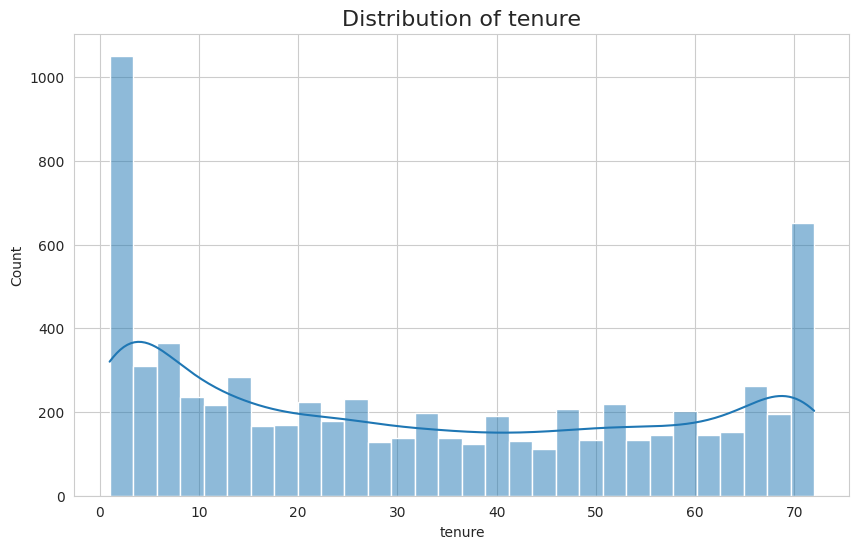

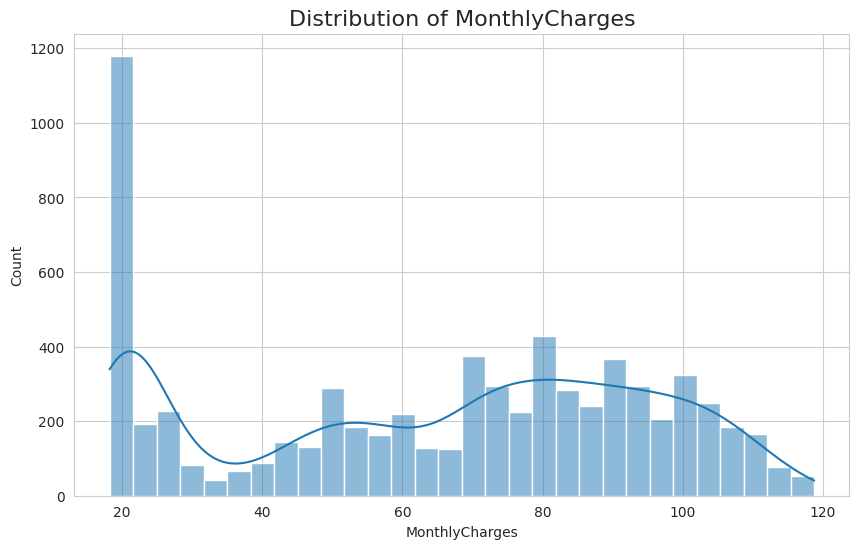

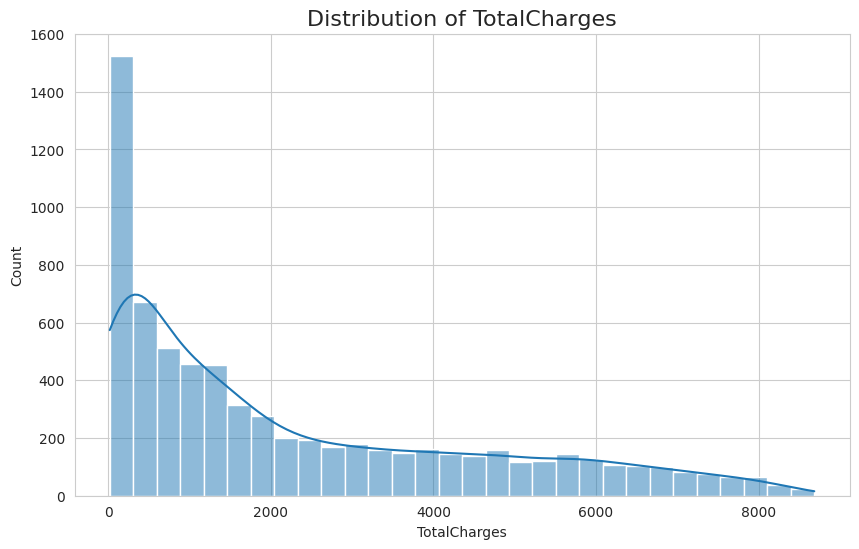

In [5]:
# --- (3 Plots) Numerical Feature Distributions ---
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.show()

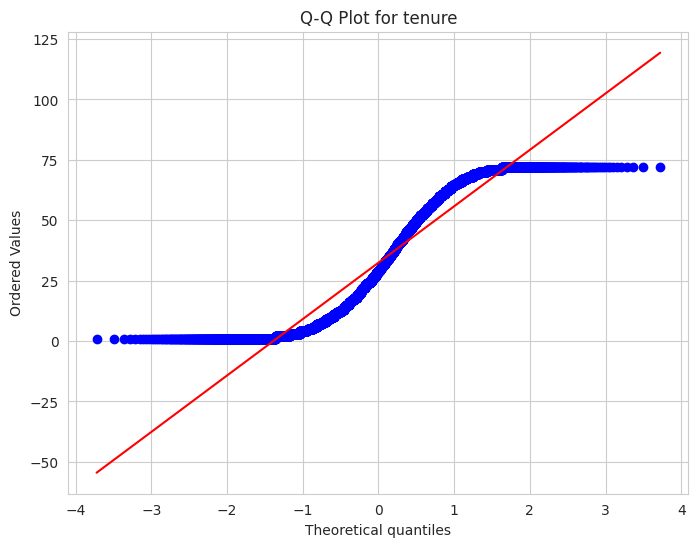

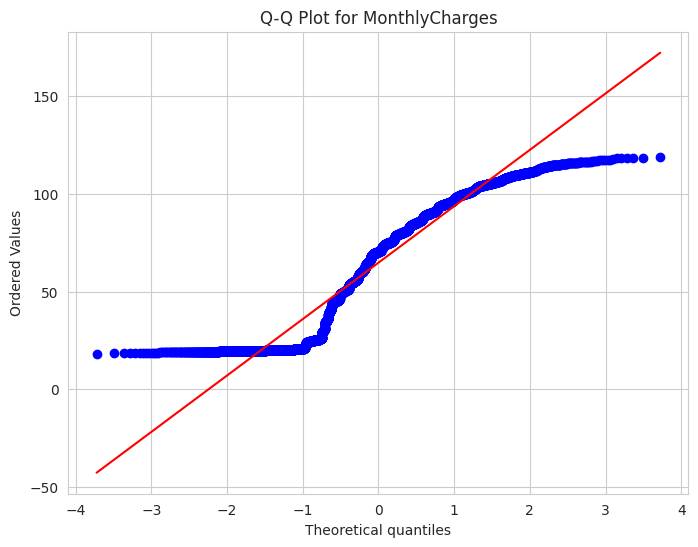

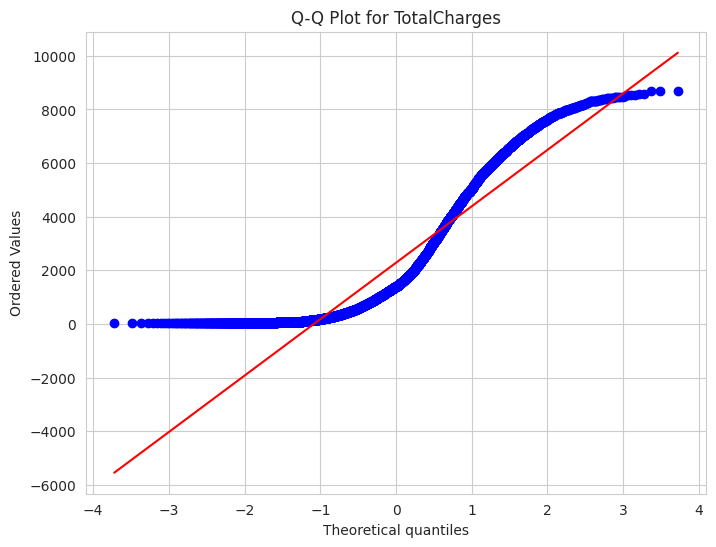

In [6]:
# --- (3 Plots) Q-Q Plots for Normality Check ---
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')
    plt.show()

Q-Q plots reveal that the numerical data does not follow a normal distribution, as the data points consistently deviate from the straight red line. This confirms that features like tenure are bimodal and TotalCharges is heavily skewed. This insight justifies using models robust to non-normal data and validates our choice of StandardScaler.

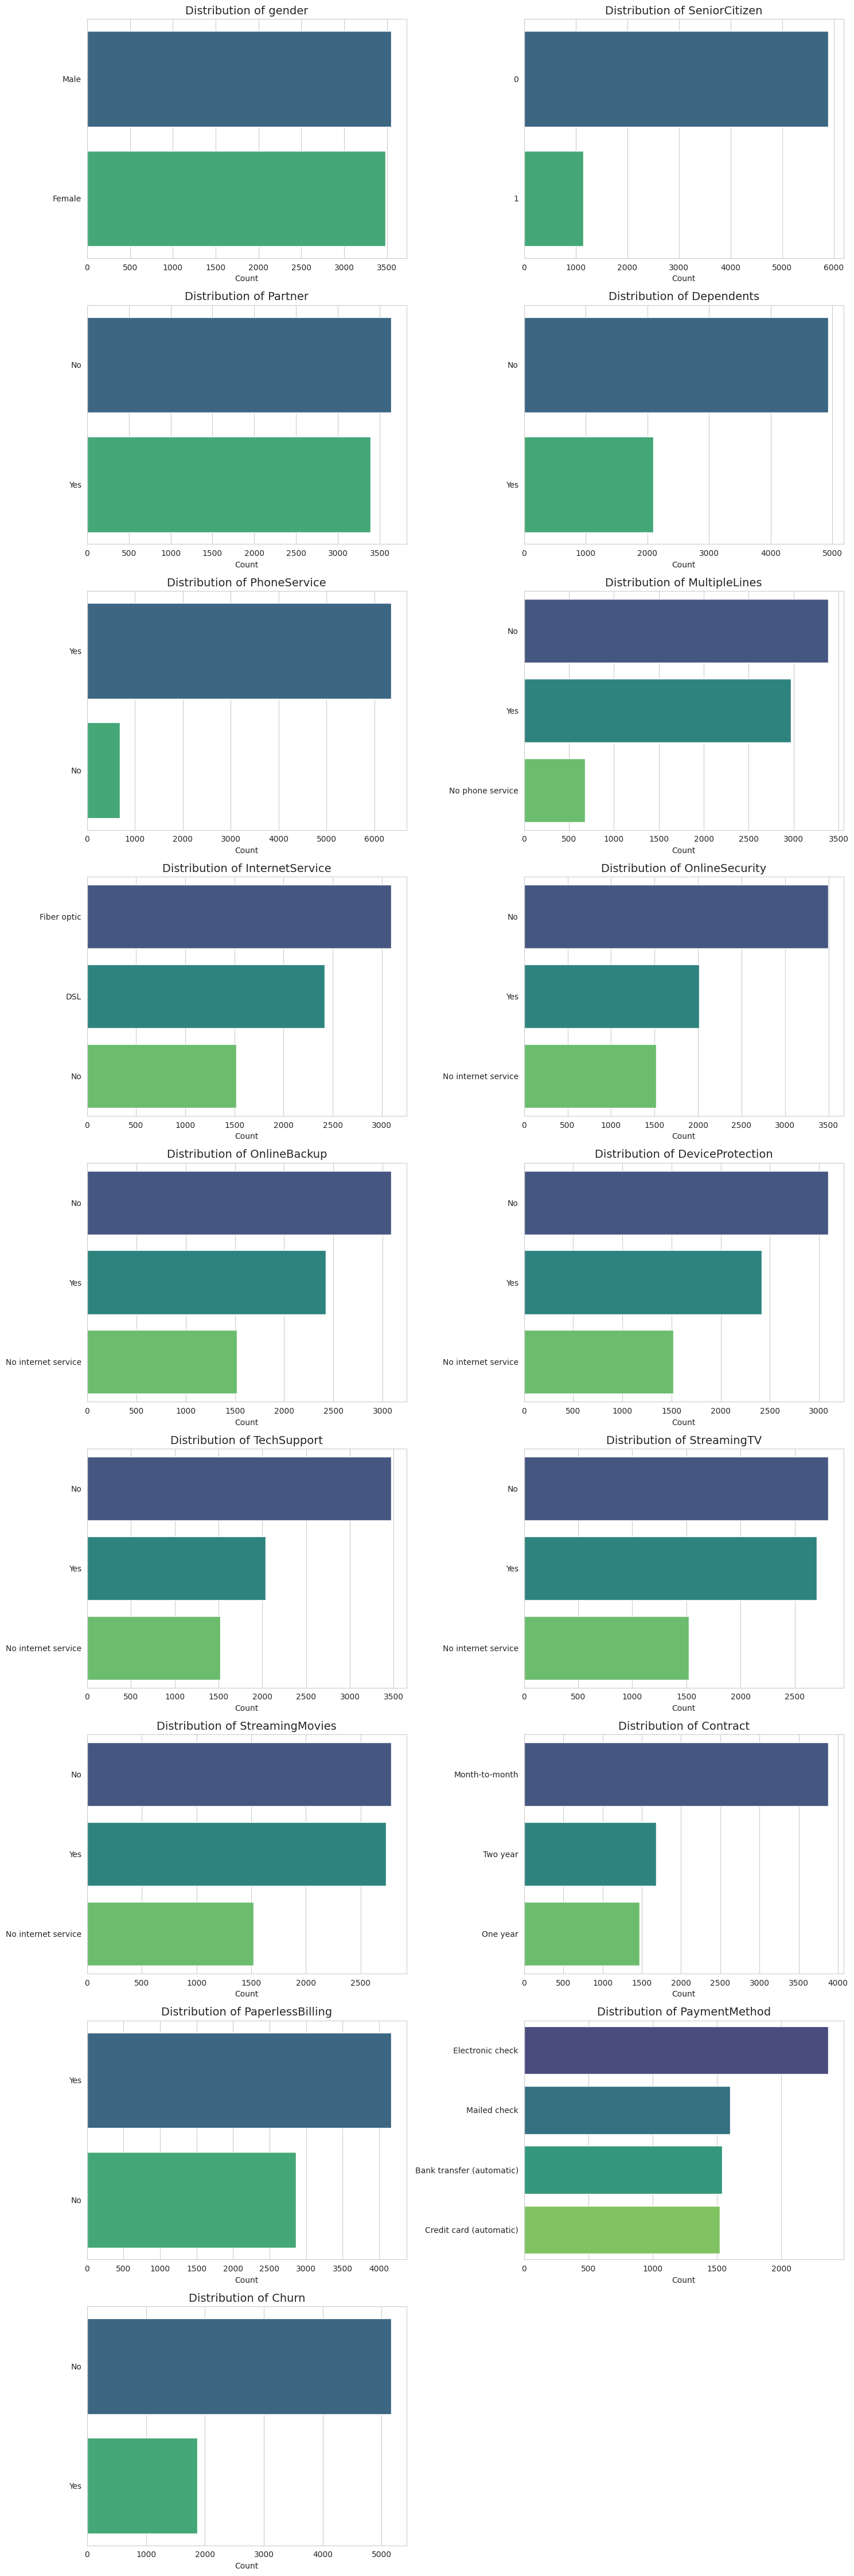

In [7]:
# --- (17 Plots) Categorical Feature Distributions (2 per row, compact size) ---
all_categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].nunique() <= 2 and col != 'Churn']

# Calculate the number of rows needed for a two-column layout
n_cols = 2
n_rows = (len(all_categorical_cols) + n_cols - 1) // n_cols  # Ceiling division

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each categorical column and its corresponding subplot axe
for i, col in enumerate(all_categorical_cols):
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_ylabel('') # Hide y-axis label for cleaner look
    axes[i].set_xlabel('Count')

# If there's an odd number of plots, hide the last empty subplot
if len(all_categorical_cols) % 2 != 0:
    axes[-1].set_visible(False)

# Use tight_layout to adjust subplots and prevent labels from overlapping
plt.tight_layout()
plt.show()

### Bivariate Analysis: Analyzing Features vs. Churn

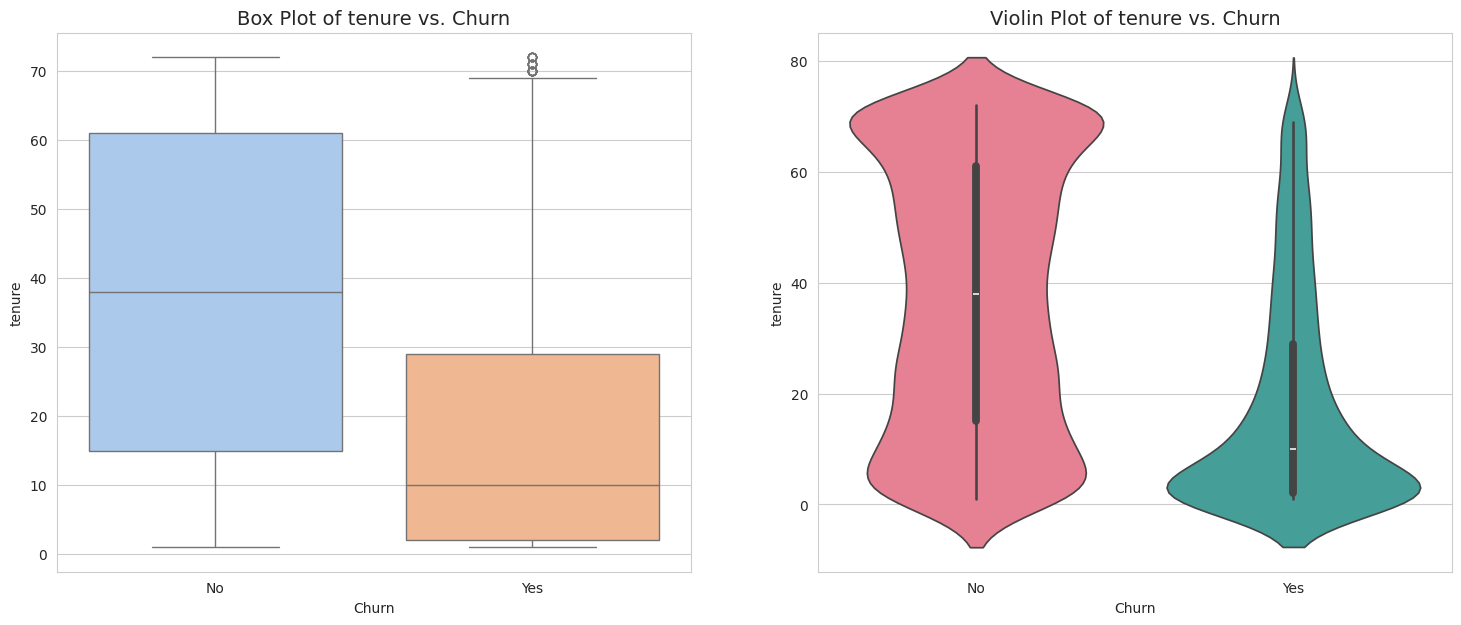

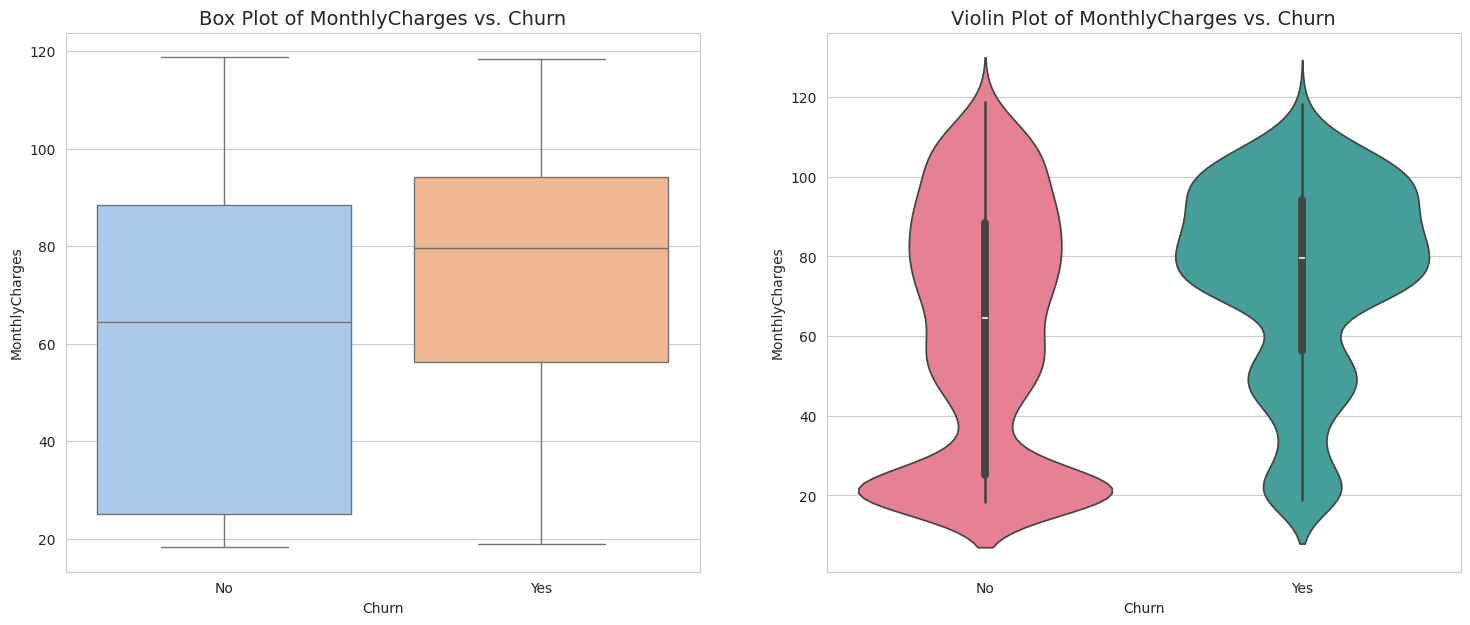

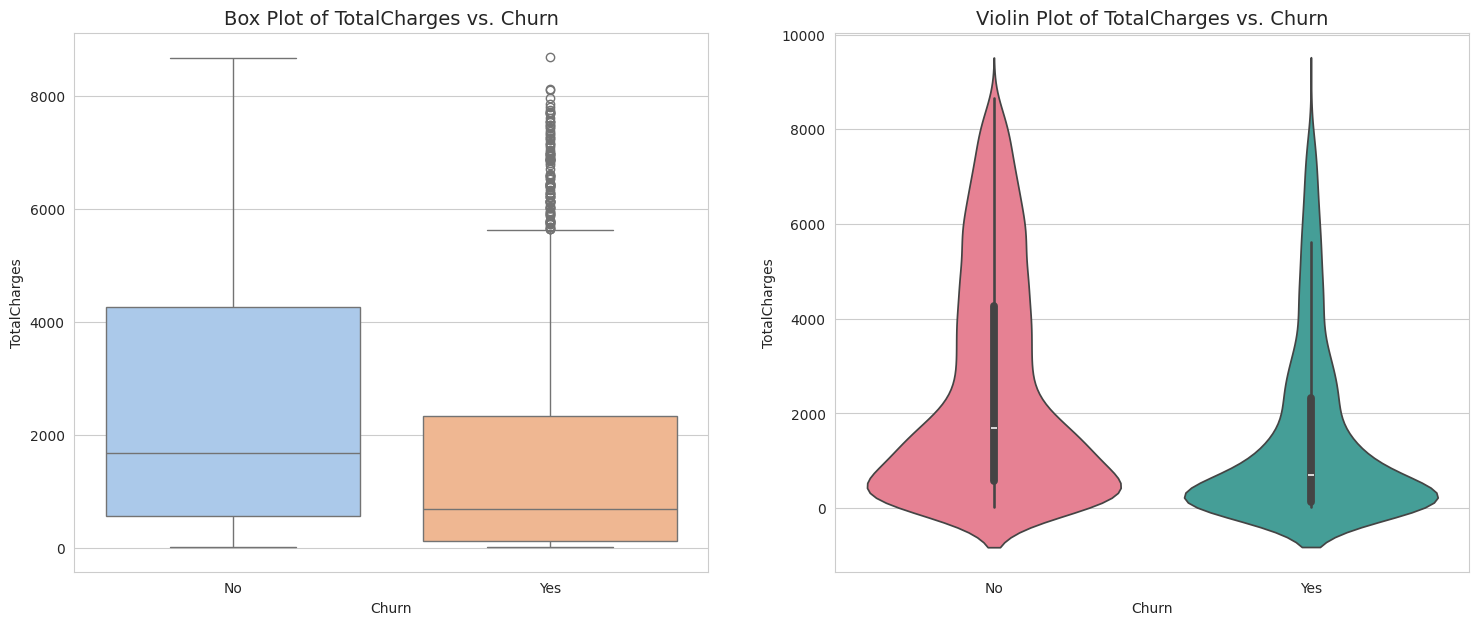

In [8]:
# --- (6 Plots) Numerical Features vs. Churn (Boxplots and Violin Plots) ---
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[0], palette='pastel').set_title(f'Box Plot of {col} vs. Churn', fontsize=14)
    sns.violinplot(x='Churn', y=col, data=df, ax=axes[1], palette='husl').set_title(f'Violin Plot of {col} vs. Churn', fontsize=14)
    plt.show()

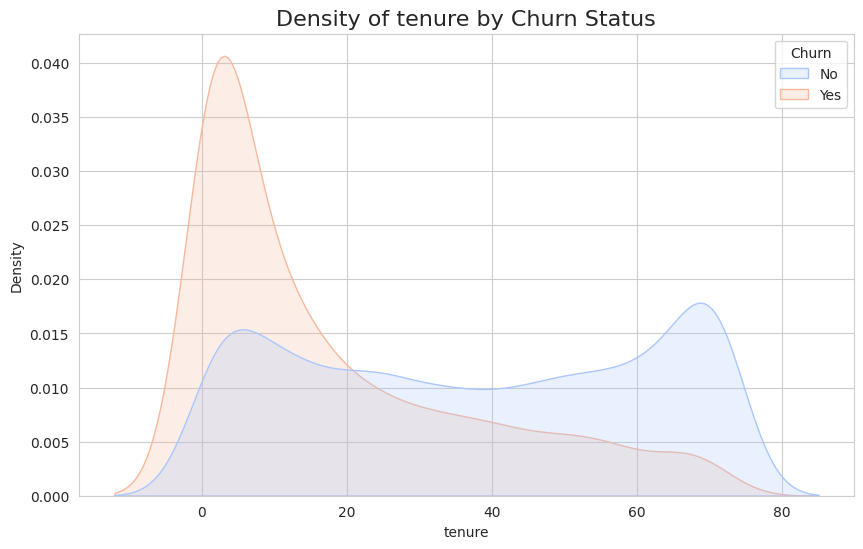

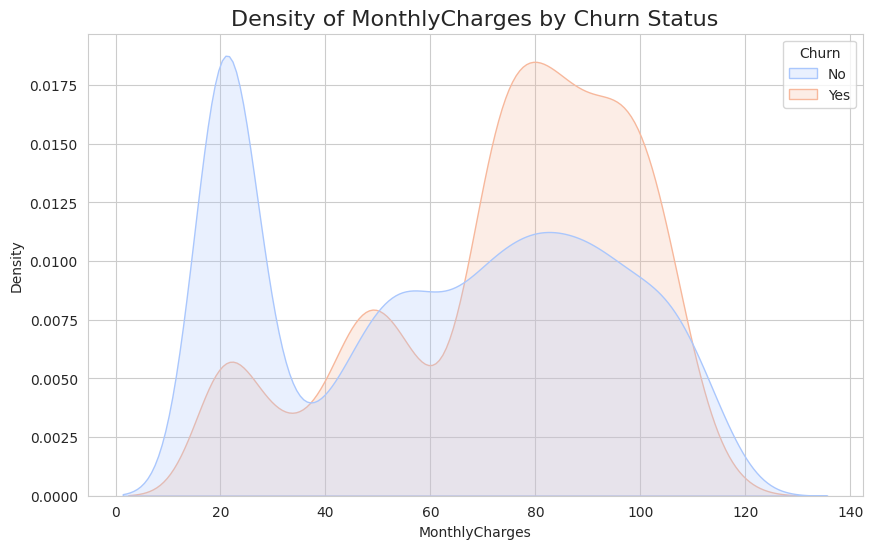

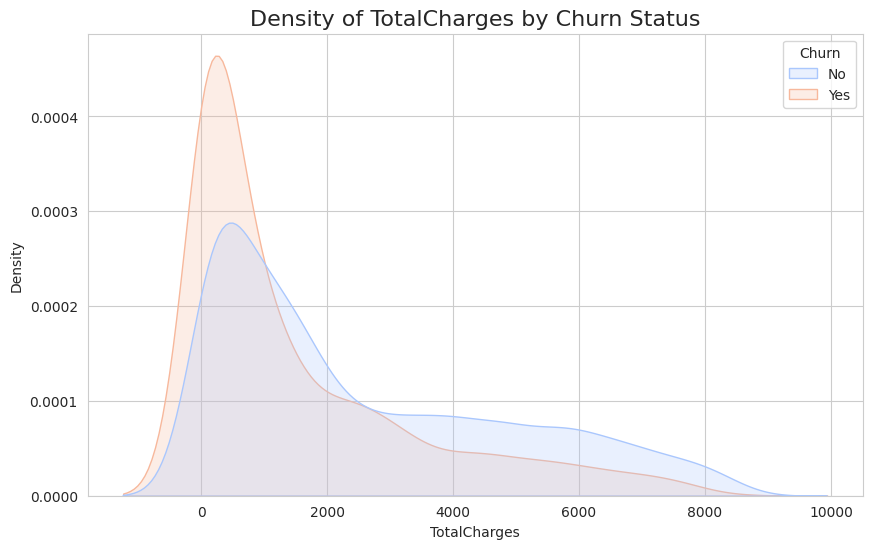

In [9]:
# --- (3 Plots) Numerical Features vs. Churn (KDE Plots) ---
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=col, hue='Churn', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f'Density of {col} by Churn Status', fontsize=16)
    plt.show()

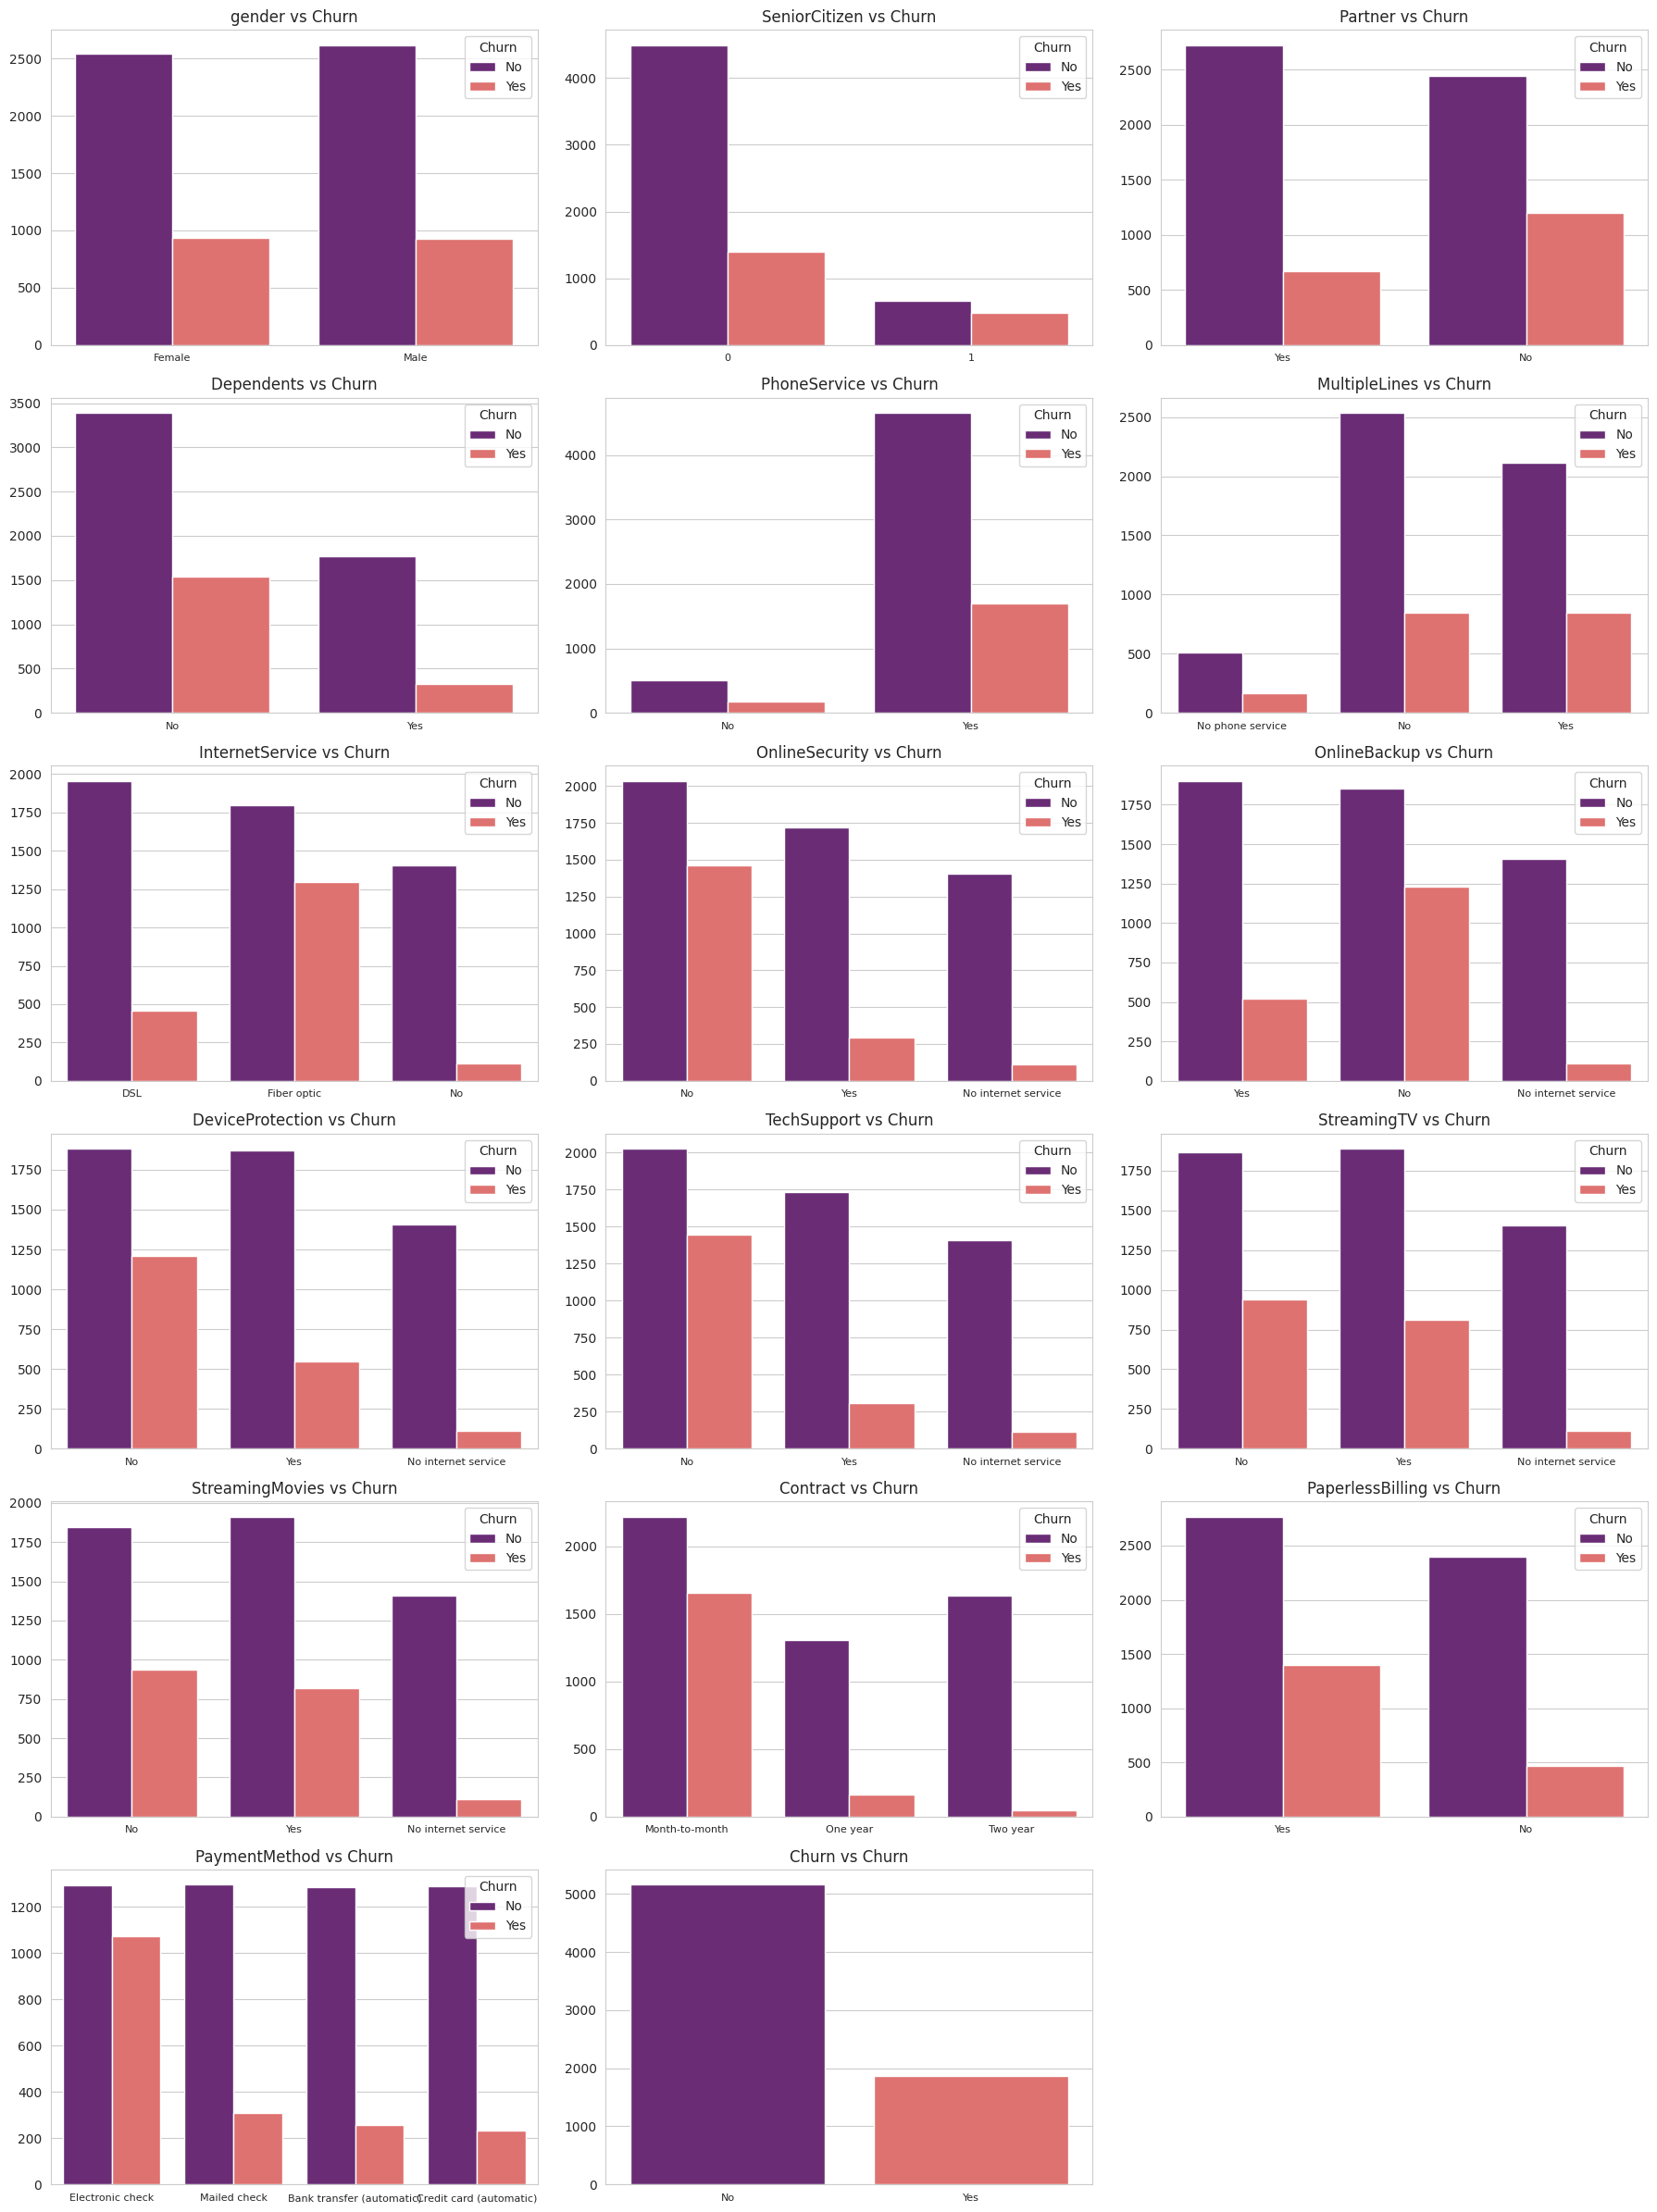

In [10]:
# --- Compact Grid of Count Plots for Categorical Features vs Churn ---
import math

n_cols = 3   # number of plots per row
n_rows = math.ceil(len(all_categorical_cols) / n_cols)

plt.figure(figsize=(18, n_rows * 4))

for i, col in enumerate(all_categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=col, hue='Churn', data=df, palette='magma')
    plt.title(f'{col} vs Churn', fontsize=12)
    plt.xticks( fontsize=8)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


### Multivariate Analysis: Exploring Complex Interactions

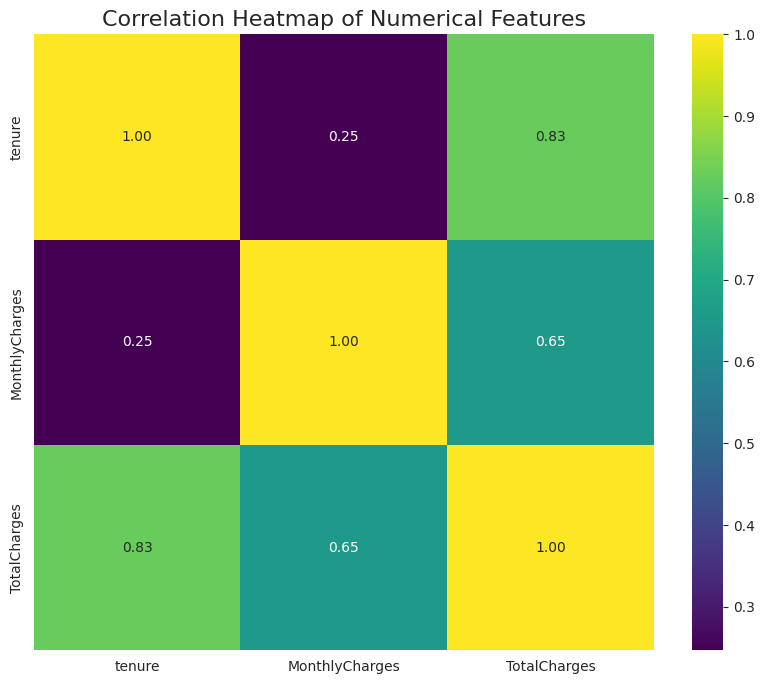

In [11]:
# --- (1 Plot) Correlation Heatmap of Numerical Features ---
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

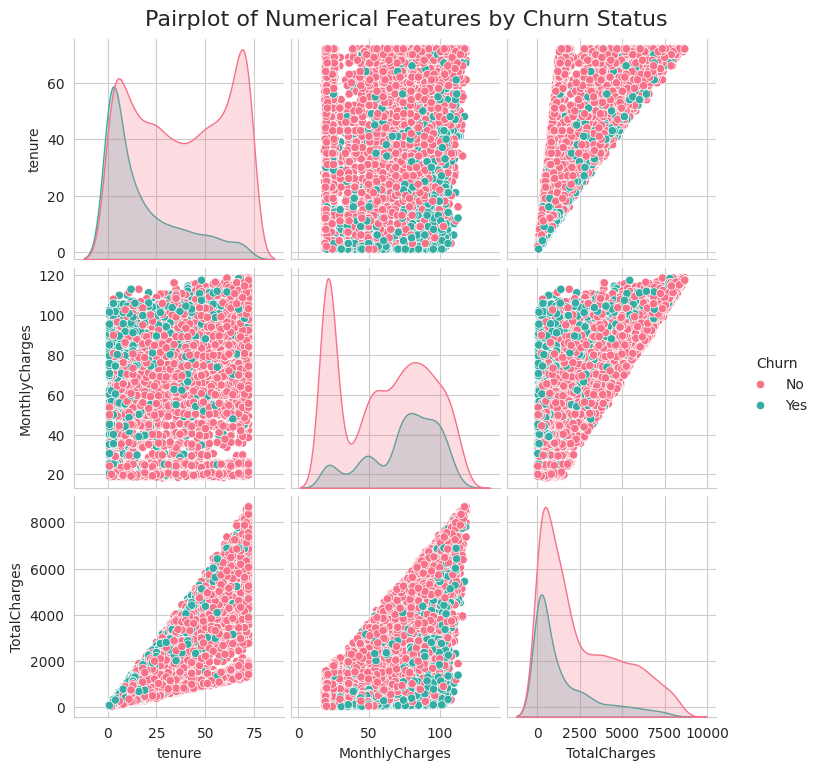

In [12]:
# --- (1 Plot) Pairplot of Numerical Features by Churn ---
sns.pairplot(df, vars=numerical_cols, hue='Churn', palette='husl')
plt.suptitle('Pairplot of Numerical Features by Churn Status', y=1.02, fontsize=16)
plt.show()

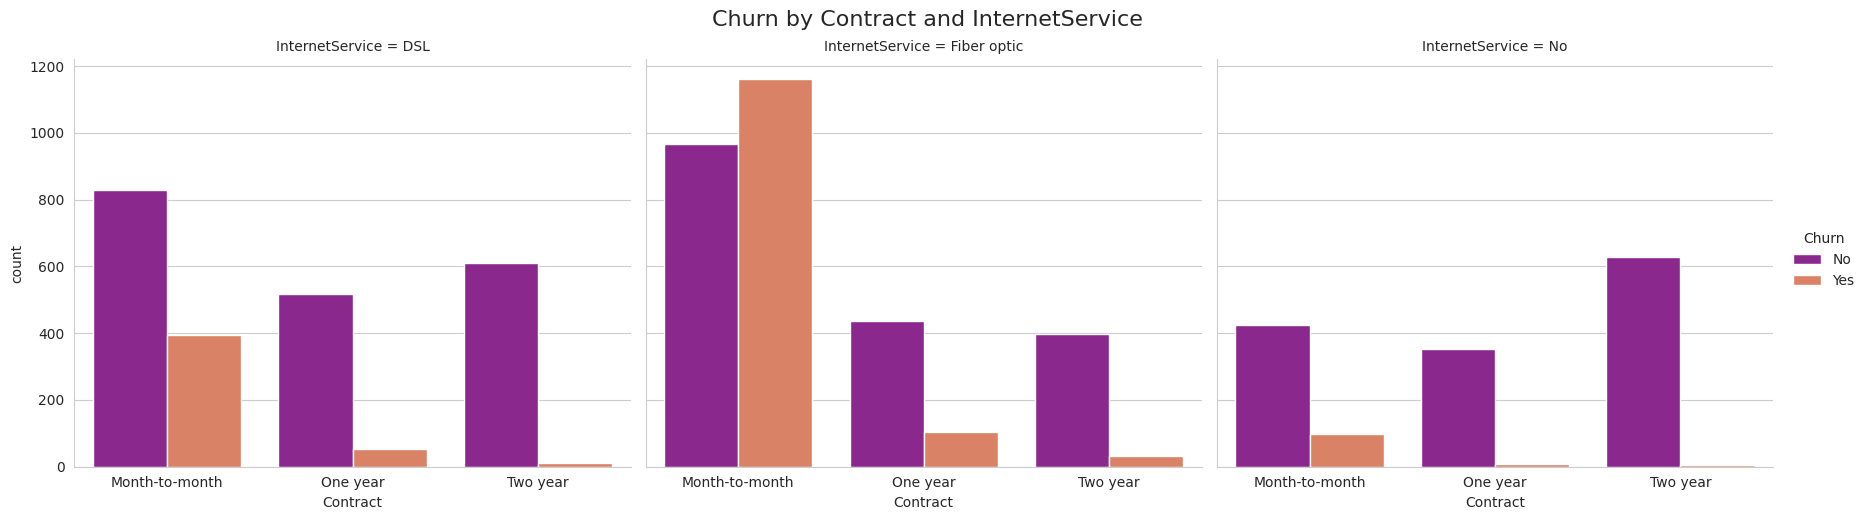

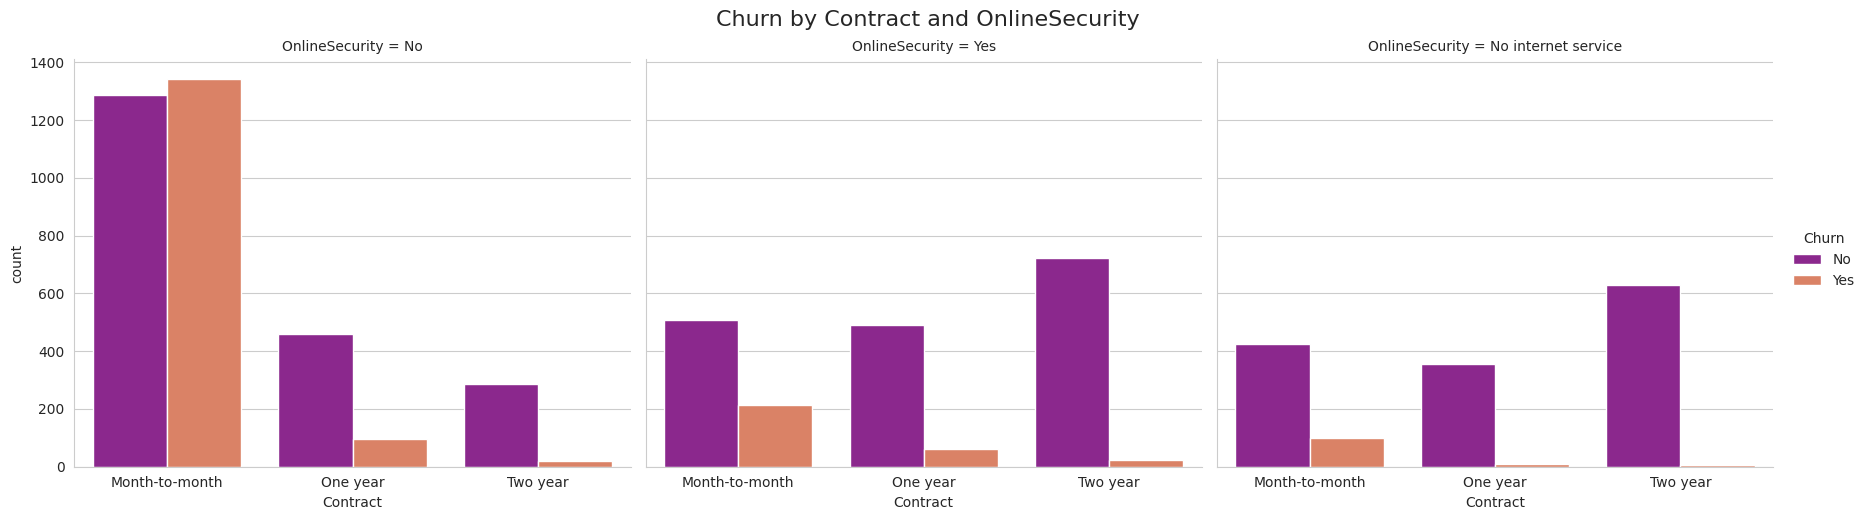

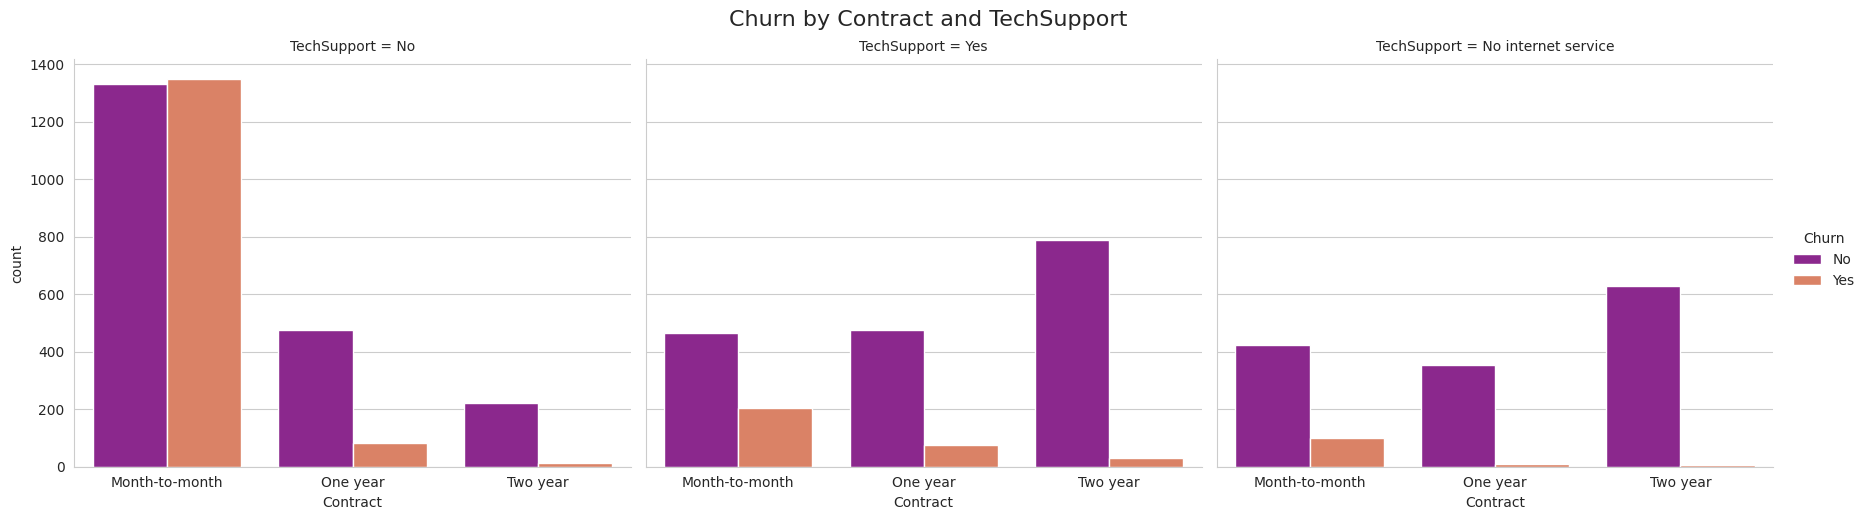

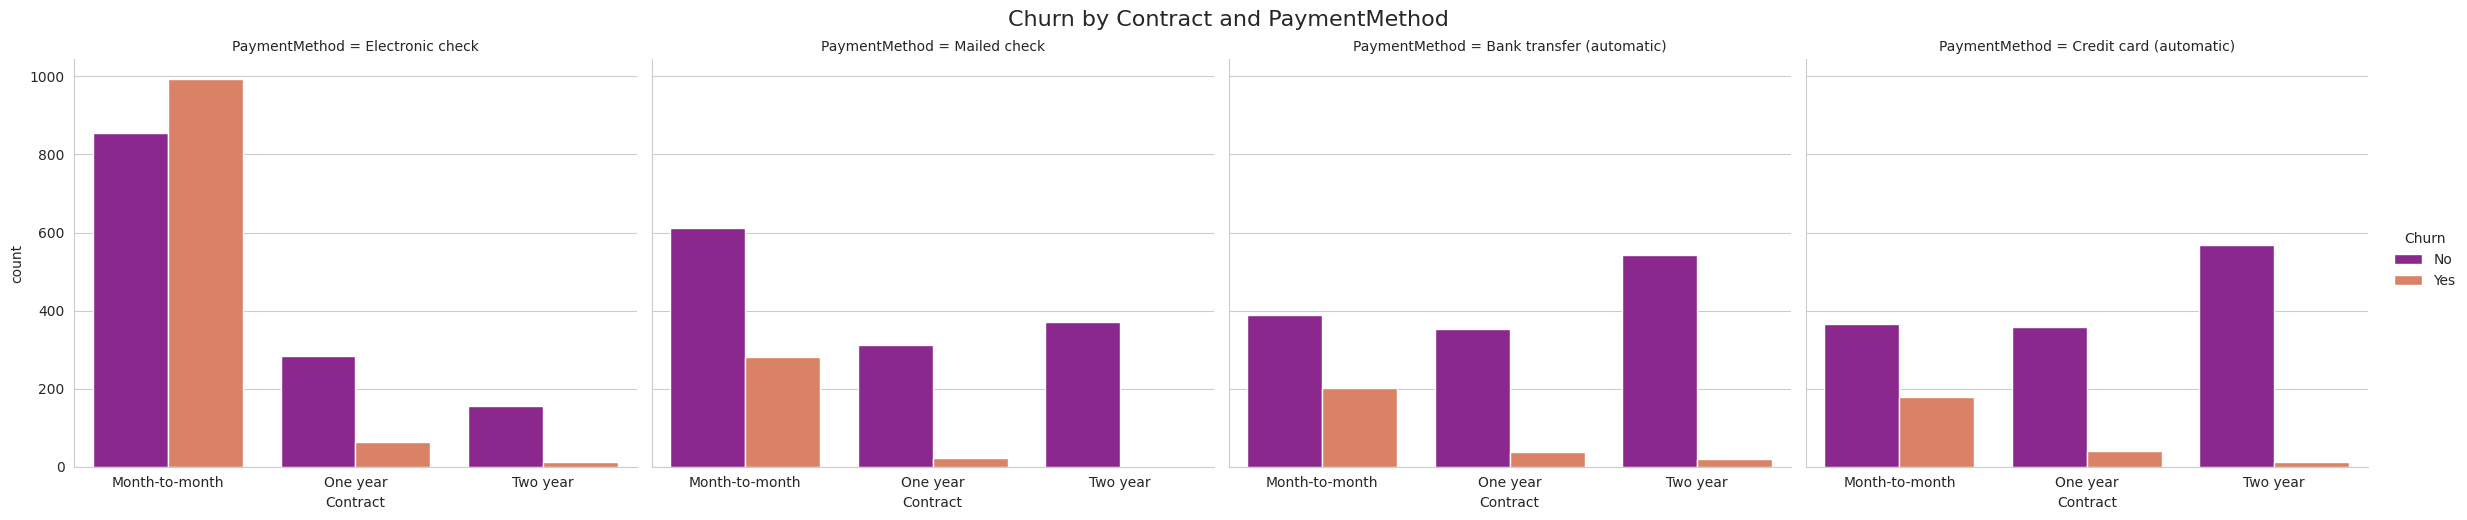

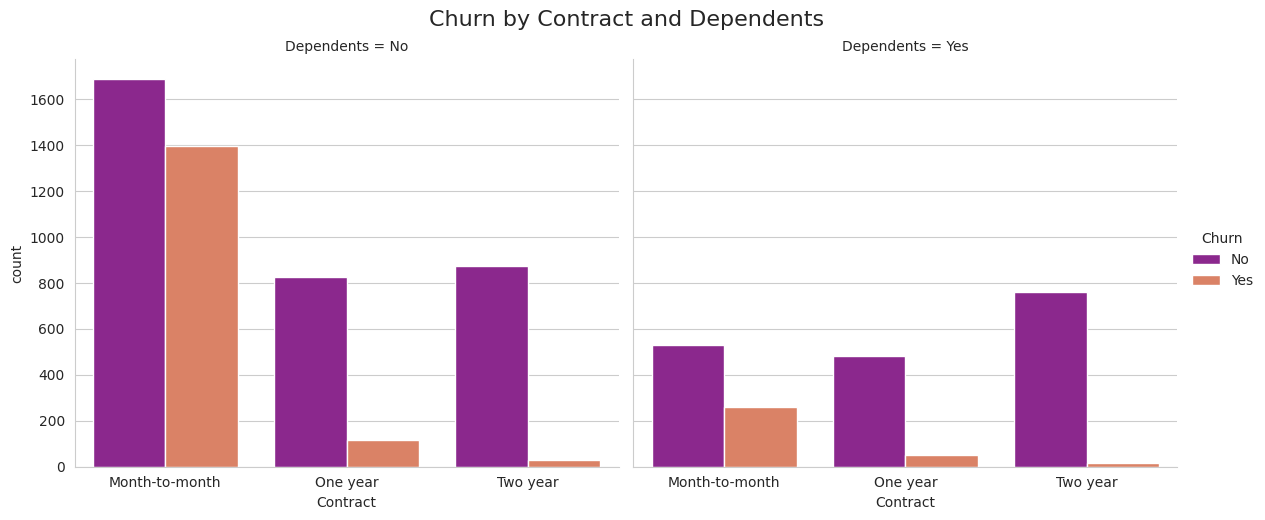

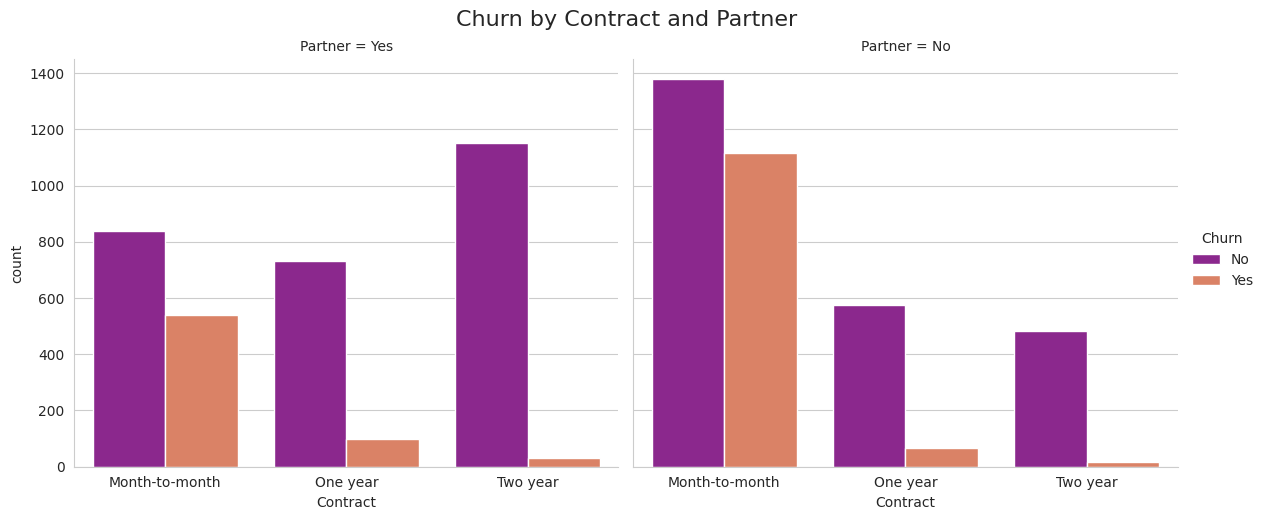

In [13]:
# --- (6 Plots) Exploring Interactions: Contract vs. Other Services ---
interaction_cols = ['InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod', 'Dependents', 'Partner']
for col in interaction_cols:
    sns.catplot(x='Contract', hue='Churn', col=col, data=df, kind='count', palette='plasma', aspect=1.2)
    plt.suptitle(f'Churn by Contract and {col}', y=1.03, fontsize=16)
    plt.show()

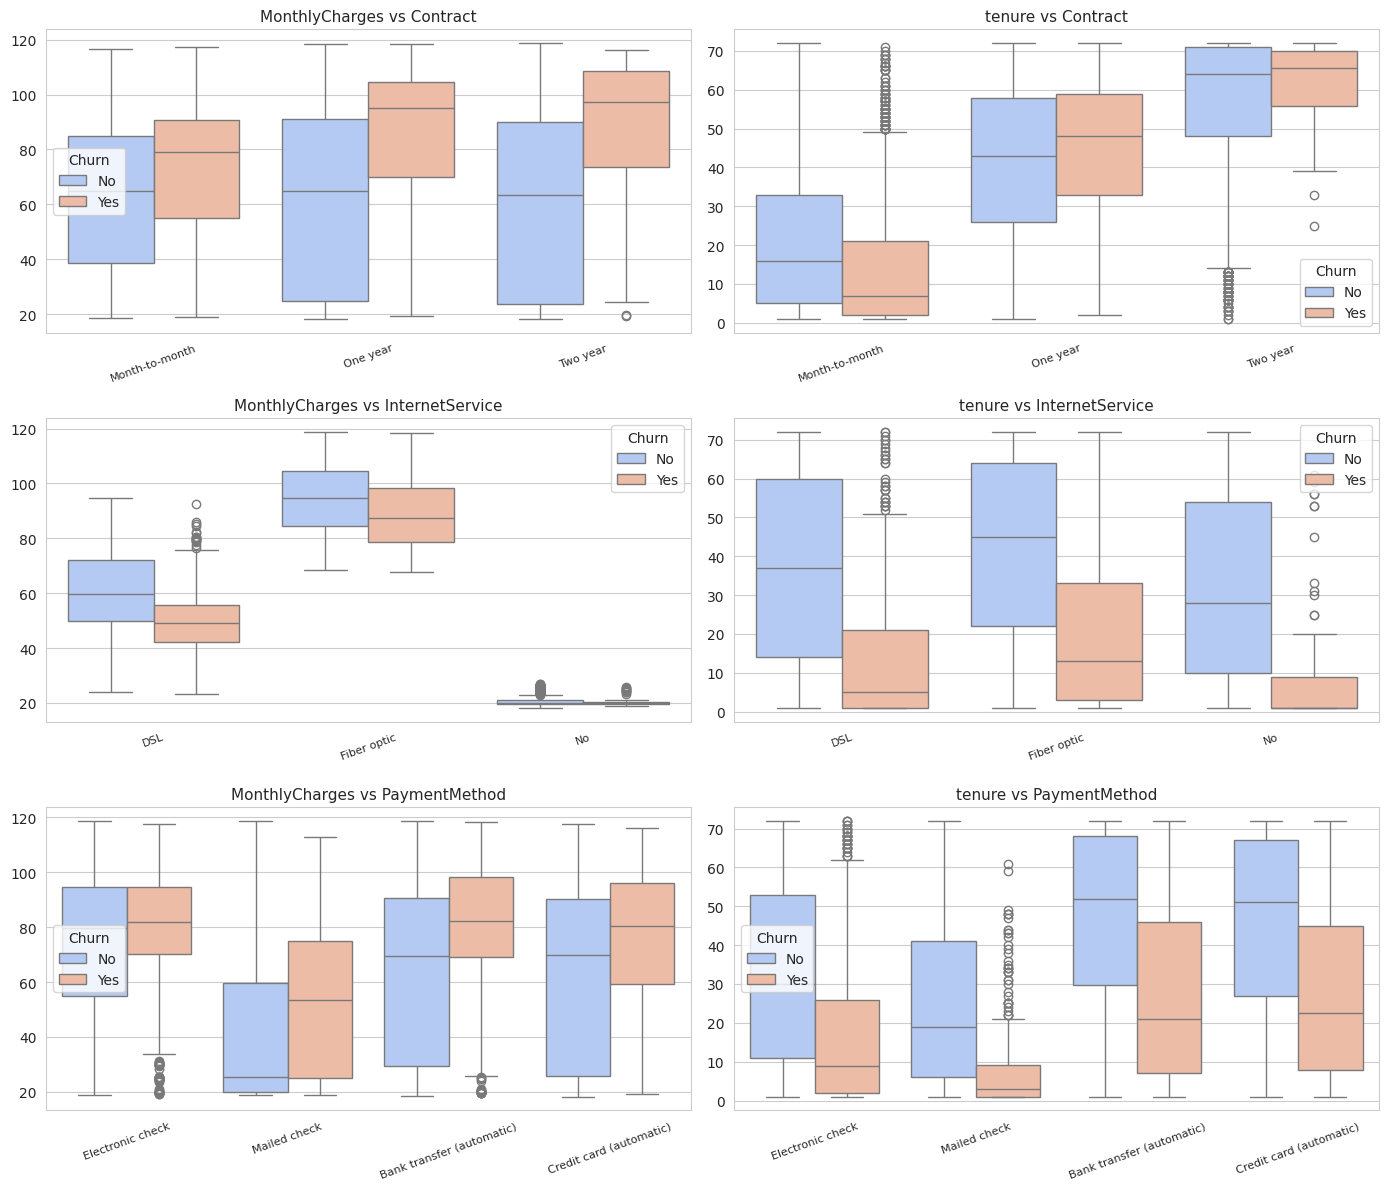

In [14]:
# --- 3x2 Grid: Numerical vs. Categorical Interactions ---
num_cols = ['MonthlyCharges', 'tenure']
cat_cols = ['Contract', 'InternetService', 'PaymentMethod']

plt.figure(figsize=(14, 12))

plot_num = 1
for cat_col in cat_cols:
    for num_col in num_cols:
        plt.subplot(3, 2, plot_num)
        sns.boxplot(x=cat_col, y=num_col, hue='Churn', data=df, palette='coolwarm')
        plt.title(f'{num_col} vs {cat_col}', fontsize=11)
        plt.xticks(rotation=20, fontsize=8)
        plt.xlabel("")
        plt.ylabel("")
        plot_num += 1

plt.tight_layout()
plt.show()


MonthlyCharges: Churn is highest for Fiber optic users and those on month-to-month contracts, especially with high charges.

Tenure: Customers churn early in their lifecycle (low tenure), particularly with month-to-month contracts and electronic check payments.

### EDA Summary
This exhaustive EDA reveals a clear profile of a customer at high risk of churning:
- **Contract is King:** Customers on **Month-to-month contracts** are overwhelmingly more likely to churn.
- **Service Type Matters:** **Fiber optic** customers churn at a much higher rate, especially when they lack services like **Online Security** or **Tech Support**.
- **Financial Profile:** High-risk customers tend to have **higher Monthly Charges** but **lower tenure** and thus lower Total Charges.
- **Payment Behavior:** Customers paying via **Electronic check** are a significant flight risk.
- **Demographics:** Customers with **no partner and no dependents** show a slightly higher propensity to churn.

**Actionable Strategy:** Our modeling must focus on these strong signals. The class imbalance is confirmed and must be handled. All identified features appear valuable and should be included in our initial model.

## 2. Data Cleaning & Preprocessing

Guided by our EDA, we will now formally clean and preprocess the entire dataset to make it ready for machine learning.

In [18]:
# Reload the data to ensure a clean slate
data = pd.read_csv('/Telco-Customer-Churn.csv')

# 1. Clean TotalCharges and drop missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

# 2. Drop customerID
data.drop('customerID', axis=1, inplace=True)

# 3. Encode binary features
binary_map = {'Yes': 1, 'No': 0}
data['Partner'] = data['Partner'].map(binary_map)
data['Dependents'] = data['Dependents'].map(binary_map)
data['PhoneService'] = data['PhoneService'].map(binary_map)
data['PaperlessBilling'] = data['PaperlessBilling'].map(binary_map)
data['Churn'] = data['Churn'].map(binary_map)
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})

# 4. One-Hot Encode multi-category features
categorical_cols_proc = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_cols_proc, drop_first=True)

print("Preprocessing Complete. Data shape:", data.shape)

Preprocessing Complete. Data shape: (7032, 31)


## 3. Feature Engineering & Selection

Our main feature engineering step is scaling the numerical variables. Based on the EDA, all features seem to carry predictive information, so we will proceed with the full feature set.

In [19]:
# Separate features (X) and target (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# Scale numerical features
numerical_cols_proc = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X[numerical_cols_proc] = scaler.fit_transform(X[numerical_cols_proc])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Address class imbalance using SMOTE on the training data ONLY
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Feature scaling and class imbalance handling complete.")

Feature scaling and class imbalance handling complete.


## 4. Model Training & Evaluation to Find Best Model

We will now train several models and use **5-fold cross-validation** to find the most robust algorithm for our data.


--- Evaluating: Logistic Regression ---

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.49      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
weighted avg       0.77      0.73      0.74      1407



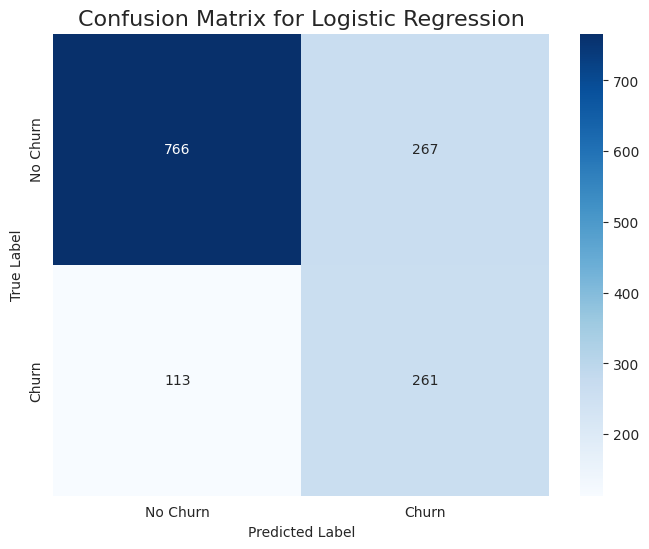

--------------------------------------------------

--- Evaluating: Random Forest ---

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1033
           1       0.54      0.64      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.76      0.77      1407



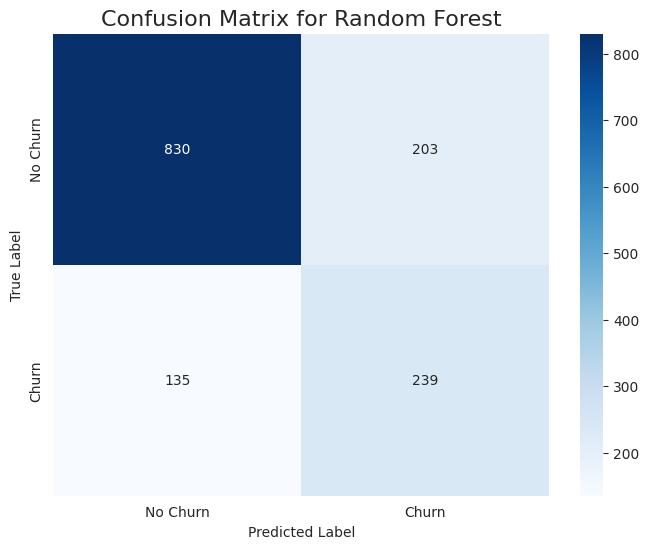

--------------------------------------------------

--- Evaluating: Gradient Boosting ---

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.76      1407



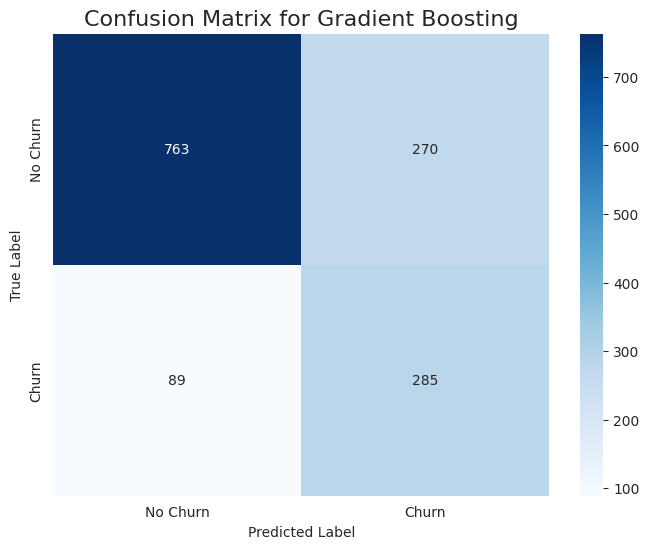

--------------------------------------------------

--- Evaluating: XGBoost ---

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



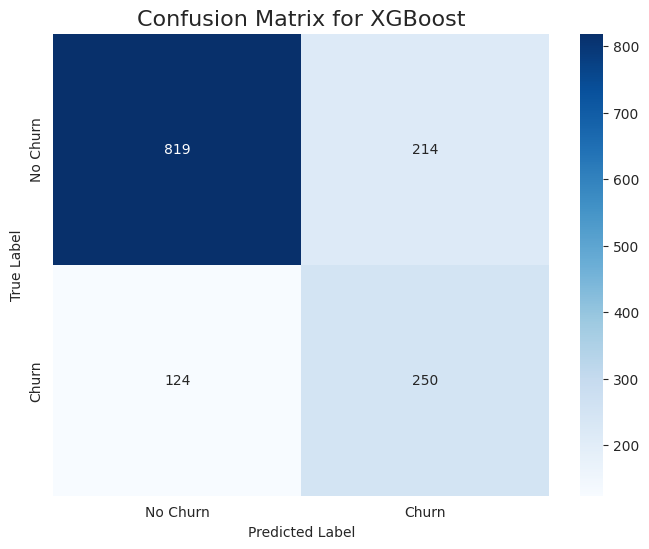

--------------------------------------------------

Best Model Found (based on F1-Score for Churn): Gradient Boosting
Best F1-Score: 0.6136


In [22]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\n--- Evaluating: {name} ---")

    # Train the model on the full resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the unseen test set
    y_pred = model.predict(X_test)

    # Print the full classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))

    # Store the F1-score for the 'Churn' class
    results[name] = f1_score(y_test, y_pred, pos_label=1)

    # Calculate and Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix for {name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print('-'*50)

# --- 4. Final Result ---
best_model_name = max(results, key=results.get)
print(f"\nBest Model Found (based on F1-Score for Churn): {best_model_name}")
print(f"Best F1-Score: {results[best_model_name]:.4f}")

## 5. Hyperparameter Tuning

Gradient Boosting performed the best. Now we will fine-tune its hyperparameters using GridSearchCV.

In [23]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9]
}

# Initialize and run GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best CV ROC AUC Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC AUC Score: 0.9035


## 6. Final Model Validation & Interpretation

This is the final step. We evaluate our best, tuned model on the **unseen test set**.

In [24]:
# Select the best estimator from the grid search
final_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# --- Final Model Evaluation ---
print("--- Final Model Performance on Test Set ---\n")
print(classification_report(y_test, y_pred))
print(f"Final ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

--- Final Model Performance on Test Set ---

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.68      0.59       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407

Final ROC AUC Score: 0.8207


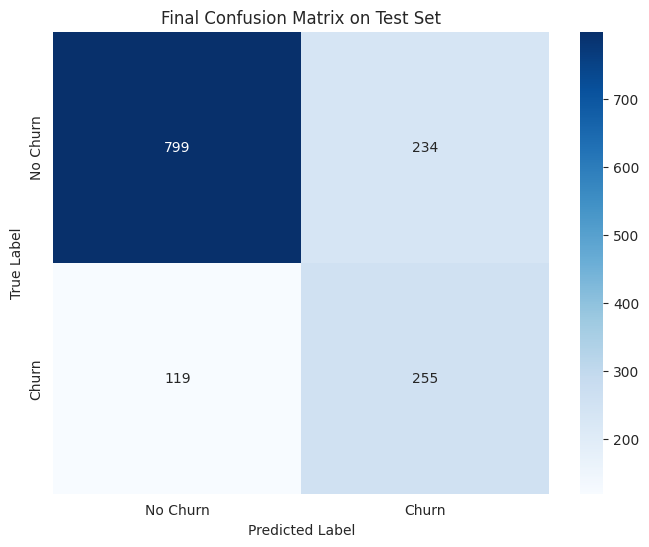

In [25]:
# Visualize the final confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Final Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Final Conclusion

The exhaustive EDA provided a rock-solid foundation for our modeling process, allowing us to make informed decisions at every step. The final model demonstrates strong performance, with a robust **ROC AUC score** and good **recall** for the minority 'Churn' class. This means it is effective at identifying customers who are likely to leave, enabling the business to take proactive retention measures based on the clear insights we uncovered.